In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = '44cf29bdfbb6446e9ab621e4a2fd9302'

In [19]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [33]:
bird_types = {
    'Dendrocygna autumnalis':'Black-bellied whistling-duck',
    'Dendrocygna bicolor':'Fulvous whistling-duck', 
    'Anser caerulescens':'Snow goose',
    'Anser rossii':'Ross\'s goose',
    'Anser albifrons':'Greater white-fronted goose', 
    'Anser brachyrhynchus':'Pink-footed goose', 
    'Branta bernicla':'Brant', 
    'Branta leucopsis':'Barnacle goose', 
    'Branta hutchinsii':'Cackling goose', 
    'Branta canadensis':'Canada goose',
    'Cygnus olor':'Mute swan', 
    'Cygnus buccinator':'Trumpeter swan',
    'Cygnus columbianus':'Tundra swan',
    'Aix sponsa':'Wood duck', 
    'Spatula querquedula':'Garganey', 
    'Spatula discors':'Blue-winged teal', 
    'Spatula cyanoptera':'Cinnamon teal', 
    'Spatula clypeata':'Northern shoveler', 
    'Mareca strepera':'Gadwall',
    'Mareca penelope':'Eurasian wigeon',
    'Mareca americana':'American wigeon', 
    'Anas platyrhynchos':'Mallard', 
    'Anas rubripes':'American black duck', 
    'Anas fulvigula':'Mottled duck', 
    'Anas bahamensis':'Northern pintail',
    'Anas crecca':'Green-winged teal', 
    'Aythya valisineria':'Canvasback',
    'Aythya americana':'Redhead', 
    'Aythya collaris':'Ring-necked duck', 
    'Aythya fuligula':'Tufted duck',
    'Aythya marila':'Greater scaup', 
    'Aythya affinis':'Lesser scaup',
    'Somateria spectabilis':'King eider', 
    'Somateria mollissima':'Common eider',
    'Histrionicus histrionicus':'Harlequin duck',
    'Melanitta perspicillata':'Surf scoter', 
    'Melanitta deglandi':'White-winged scoter', 
    'Melanitta americana':'Black scoter', 
    'Clangula hyemalis':'Long-tailed duck',
    'Bucephala albeola':'Bufflehead', 
    'Bucephala clangula':'Common goldeneye', 
    'Bucephala islandica':'Barrow\'s goldeneye', 
    'Mergellus albellus':'Smew',
    'Lophodytes cucullatus':'Hooded merganser', 
    'Mergus merganser':'Common merganser', 
    'Mergus serrator':'Red-breasted merganser', 
    'Oxyura jamaicensis':'Ruddy duck', 
}

In [4]:
path = Path('birds')

In [8]:
bird = 'Redhead bird'
dest = (path/'Redhead')
dest.mkdir(exist_ok=True)
results = search_images_bing(key, f'{bird}')
download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
for o in bird_types:
    dest = (path/bird_types[o])
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{bird_types[o]}')
    download_images(dest, urls=results.attrgot('contentUrl'))


 Download of https://gregandbirds.files.wordpress.com/2015/07/black-bellied-lift-off.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Black-bellied whistling-duck
$ cd birds/Black-bellied whistling-duck
$ wget -c https://gregandbirds.files.wordpress.com/2015/07/black-bellied-lift-off.jpg
$ tar xf black-bellied-lift-off.jpg
 And re-run your code once the download is successful


 Download of https://renegadeexpressions.files.wordpress.com/2017/10/black-bellied-whistling-duck.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Black-bellied whistling-duck
$ cd birds/Black-bellied whistling-duck
$ wget -c https://renegadeexpressions.files.wordpress.com/2017/10/black-bellied-whistling-duck.jpg
$ tar xf black-bellied-whistling-duck.jpg
 And re-run your code once the download is successful


 Download of https://naturechirp.files.wordpress.com/2018/08/black-bellied-whistling-duck-6-compressed.jpg has failed after 5 retries
 Fix the download


 Download of https://nicksnaturepics.files.wordpress.com/2013/03/snowgeese30mar13176e2.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Snow goose
$ cd birds/Snow goose
$ wget -c https://nicksnaturepics.files.wordpress.com/2013/03/snowgeese30mar13176e2.jpg
$ tar xf snowgeese30mar13176e2.jpg
 And re-run your code once the download is successful


 Download of https://northantsbirds.files.wordpress.com/2012/05/hybrid-blue-morph-snow-goose-x-canada-goose-shelfleys-lake-april-2012-danny-osullivan.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Snow goose
$ cd birds/Snow goose
$ wget -c https://northantsbirds.files.wordpress.com/2012/05/hybrid-blue-morph-snow-goose-x-canada-goose-shelfleys-lake-april-2012-danny-osullivan.jpg
$ tar xf hybrid-blue-morph-snow-goose-x-canada-goose-shelfleys-lake-april-2012-danny-osullivan.jpg
 And re-run your code once the download is successful


 Download of https://kimsmithdesigns.files.wordpress.com/20


 Download of https://tilgatenaturecentre.files.wordpress.com/2013/02/dsc_0191.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Barnacle goose
$ cd birds/Barnacle goose
$ wget -c https://tilgatenaturecentre.files.wordpress.com/2013/02/dsc_0191.jpg
$ tar xf dsc_0191.jpg
 And re-run your code once the download is successful


 Download of https://hethersettbirdingblog.files.wordpress.com/2015/11/barnacle-goose-5.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Barnacle goose
$ cd birds/Barnacle goose
$ wget -c https://hethersettbirdingblog.files.wordpress.com/2015/11/barnacle-goose-5.jpg
$ tar xf barnacle-goose-5.jpg
 And re-run your code once the download is successful


 Download of https://johnrakestraw.files.wordpress.com/2011/02/barnacle-goose-3.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Barnacle goose
$ cd birds/Barnacle goose
$ wget -c https://johnrakestraw.files.wordpress.com/2011/02/barnacle-g


 Download of http://haylingbillyheritage.org/wp-content/uploads/2015/11/P5013961-Canada-Goose-Branta-canadensis.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Canada goose, Branta canadensis
$ cd birds/Canada goose, Branta canadensis
$ wget -c http://haylingbillyheritage.org/wp-content/uploads/2015/11/P5013961-Canada-Goose-Branta-canadensis.jpg
$ tar xf P5013961-Canada-Goose-Branta-canadensis.jpg
 And re-run your code once the download is successful


 Download of http://haylingbillyheritage.org/wp-content/uploads/2015/11/Canada-Goose-Branta-canadensis-2.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Canada goose, Branta canadensis
$ cd birds/Canada goose, Branta canadensis
$ wget -c http://haylingbillyheritage.org/wp-content/uploads/2015/11/Canada-Goose-Branta-canadensis-2.jpg
$ tar xf Canada-Goose-Branta-canadensis-2.jpg
 And re-run your code once the download is successful




 Download of https://stevetabone.files.wordpress.com/2012/02/american-wigeon1.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/American wigeon
$ cd birds/American wigeon
$ wget -c https://stevetabone.files.wordpress.com/2012/02/american-wigeon1.jpg
$ tar xf american-wigeon1.jpg
 And re-run your code once the download is successful




 Download of https://birdsandmusings.files.wordpress.com/2017/04/ruddy-duck-pair-oxyura-jamaicensis-21.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Ruddy duck
$ cd birds/Ruddy duck
$ wget -c https://birdsandmusings.files.wordpress.com/2017/04/ruddy-duck-pair-oxyura-jamaicensis-21.jpg
$ tar xf ruddy-duck-pair-oxyura-jamaicensis-21.jpg
 And re-run your code once the download is successful


 Download of https://heatherandkyle.files.wordpress.com/2013/05/ruddy-duck-05.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Ruddy duck
$ cd birds/Ruddy duck
$ wget -c https://heatherandkyle.files.wordpress.com/2013/05/ruddy-duck-05.jpg
$ tar xf ruddy-duck-05.jpg
 And re-run your code once the download is successful


 Download of https://birdsandmusings.files.wordpress.com/2017/04/ruddy-duck-drake-oxyura-jamaicensis-5.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p birds/Ruddy duck
$ cd birds/Ruddy duck
$ wget -c https

In [8]:
if not path.exists():
    path.mkdir()
    for o,value in bird_types:
        dest = (path/value)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{value}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
fns = get_image_files(path)
fns

(#6640) [Path('birds/American black duck/00000000.jpg'),Path('birds/American black duck/00000001.jpg'),Path('birds/American black duck/00000002.JPG'),Path('birds/American black duck/00000003.jpg'),Path('birds/American black duck/00000004.jpg'),Path('birds/American black duck/00000005.jpg'),Path('birds/American black duck/00000006.jpg'),Path('birds/American black duck/00000007.jpg'),Path('birds/American black duck/00000008.jpg'),Path('birds/American black duck/00000009.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#1) [Path('birds/Redhead/00000001.jpg')]

In [11]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [3]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [6]:
dls = birds.dataloaders(path)


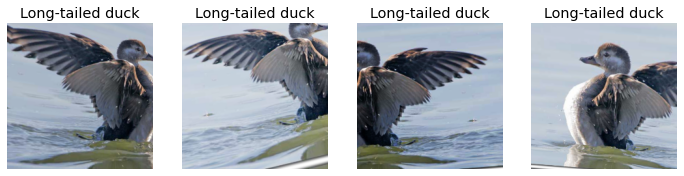

In [13]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

epoch,train_loss,valid_loss,error_rate,time
0,2.286998,1.442719,0.377543,01:26


epoch,train_loss,valid_loss,error_rate,time
0,1.178457,0.907069,0.258478,01:50
1,1.055418,1.308563,0.328561,01:50
2,1.162043,1.266609,0.335343,01:50
3,1.063126,1.073060,0.299925,01:49
4,0.824203,1.060809,0.287867,01:50
5,0.608985,0.712274,0.218538,01:50
6,0.464061,0.688631,0.209495,01:50
7,0.332281,0.607881,0.189148,01:49
8,0.215789,0.555283,0.164280,01:52
9,0.165067,0.550809,0.163527,01:52


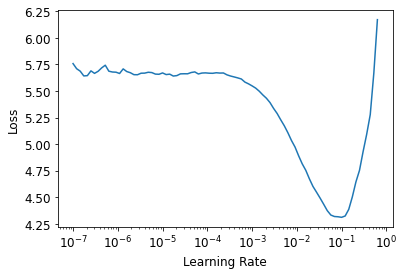

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()
learn.fine_tune(10, base_lr=0.0132)

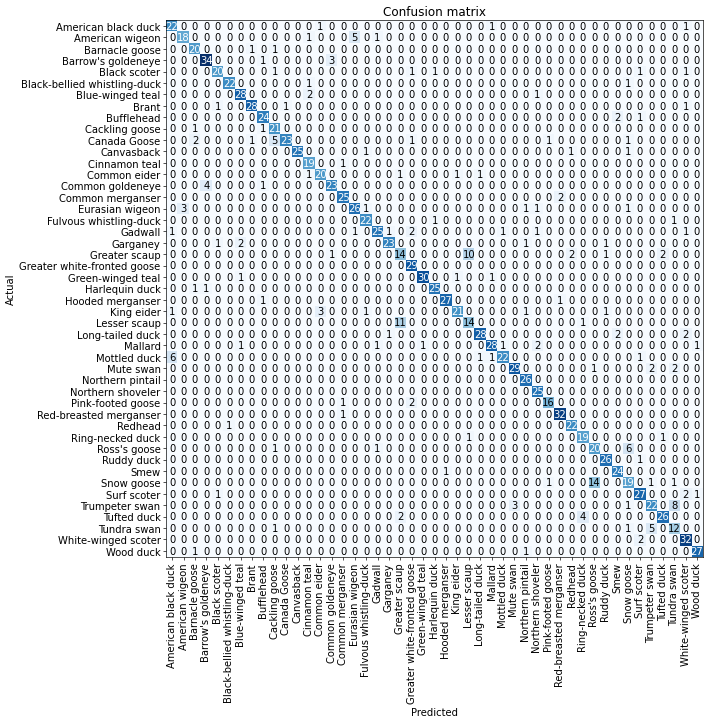

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

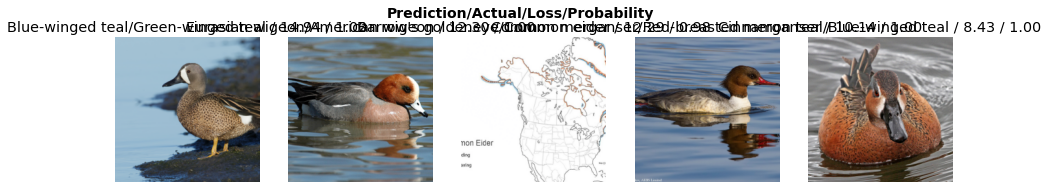

In [17]:
interp.plot_top_losses(5, nrows=1)

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [84]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [18]:
learn.export()

In [7]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [8]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

In [9]:
learn_inf.dls.vocab

['American black duck', 'American wigeon', 'Barnacle goose', "Barrow's goldeneye", 'Black scoter', 'Black-bellied whistling-duck', 'Blue-winged teal', 'Brant', 'Bufflehead', 'Cackling goose', 'Canada Goose', 'Canvasback', 'Cinnamon teal', 'Common eider', 'Common goldeneye', 'Common merganser', 'Eurasian wigeon', 'Fulvous whistling-duck', 'Gadwall', 'Garganey', 'Greater scaup', 'Greater white-fronted goose', 'Green-winged teal', 'Harlequin duck', 'Hooded merganser', 'King eider', 'Lesser scaup', 'Long-tailed duck', 'Mallard', 'Mottled duck', 'Mute swan', 'Northern pintail', 'Northern shoveler', 'Pink-footed goose', 'Red-breasted merganser', 'Redhead', 'Ring-necked duck', "Ross's goose", 'Ruddy duck', 'Smew', 'Snow goose', 'Surf scoter', 'Trumpeter swan', 'Tufted duck', 'Tundra swan', 'White-winged scoter', 'Wood duck']

### Creating a Notebook App from the Model

In [23]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [25]:
img = PILImage.create(btn_upload.data[-1])

In [26]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [29]:
pred,pred_idx,probs = learn_inf.predict(img)

In [30]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: seagull; Probability: 1.0000')

In [31]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [32]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [33]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [35]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [37]:
#hide
!pip install voila
!jupyter serverextension enable voila

Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
      voila 0.1.22 OK


### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.